Here we will demonstrate how to effectively use linear mixed models in the context of balance trees.

This will cover how to specify different treatment effects in the linear mixed models, visualize them in
ETE, and diagnostic approaches for further investigating balances.

We'll start by loading up the modules required to run this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import ilr, ilr_inv
from skbio import TreeNode
from gneiss.balances import balanceplot, balance_basis
from gneiss.layouts import barchart_layout
from gneiss.util import match, match_tips, rename_internal_nodes
from gneiss import mixedlm

from biom import load_table
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, BarChartFace
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Now we'll define a few convenience functions to cleaning up the metadata and matching the table to the metadata mapping file.

In [2]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order',
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

Now, we will create some helper functions that we will use to create new columns in our metadata mapping file - namely for potato color and potato processing type.

In [3]:
def potato_color(x):
    """ Used to create a column specifying potato color"""
    if x == 'Control_1':
        return 'Control'
    if x == 'Control_2':
        return 'HCD'
    if 'purple' in x:
        return 'purple'
    if 'white' in x:
        return 'white'
    else:
        return None
    
def potato_processing(x):
    """ Used to create a column specifying potato processing type"""
    if x == 'Control_1':
        return 'Control'
    if x == 'Control_2':
        return 'HCD'
    if 'baked' in x:
        return 'baked'
    if 'raw' in x:
        return 'raw'
    if 'chipped' in x:
        return 'chipped'
    else:
        return None

This will upload the mapping file, the OTU table and the OTU tree into memory.

In [4]:
mapping = pd.read_table('../data/1706_prep_1145_qiime_20151019-134013.txt', index_col=0)
table = load_table('../data/435_otu_table.biom')
tree = TreeNode.read('../data/97_otus.tree')

Now, we will filter out some of the samples in the metadata table, and add some additional columns for
processing type, potato color and time.

In [5]:
# filter out samples that aren't fecal
prevention_mapping = mapping.loc[mapping.sample_type=='feces']                               

# create a new column indicating potato color
prevention_mapping['color'] = prevention_mapping['treatment'].apply(potato_color)
prevention_mapping = prevention_mapping.dropna(subset=['color']) 

# create a new column indicating potato processing type
prevention_mapping['processing'] = prevention_mapping['treatment'].apply(potato_processing)

# create a new column indicating time point.
prevention_mapping['time'] = prevention_mapping.timepoint.apply(lambda x: int(x.split(' ')[1]))

prevention_mapping = prevention_mapping.loc[prevention_mapping['processing'] != 'HCD']
prevention_mapping = prevention_mapping.loc[prevention_mapping['processing'] != 'Control']

Now we will filter out OTUs with less than 100 reads, and samples with less than 100 reads.

In [6]:
read_filter = lambda val, _id, md : sum(val) > 125
md_filter = lambda val, _id, md : _id in prevention_mapping.index

table.filter(md_filter, axis='sample') # filter out samples not in the mapping file.
table.filter(read_filter, axis='observation')
table.filter(read_filter, axis='sample')

2351 x 648 <class 'biom.table.Table'> with 651003 nonzero entries (42% dense)

We will convert the biom table into two pandas dataframes for the sake of readability.

In [7]:
otu_table, taxonomy = convert_biom_to_pandas(table)

And match up the otu table and the metadata table to make sure that the samples between the 2 tables match up exactly.

In [8]:
otu_table, prevention_mapping = match(otu_table, prevention_mapping)

Now we will match up the OTU tree with the OTU table to make sure that the tips and the OTU names line up.

This will make sure that the OTU tree tips align exactly with the OTU table. 
OTUS in the table that are not present in the tree, or OTUs present in the tree but not in the OTU table will be thrown out.

In [9]:
otu_table, otu_tree = match_tips(otu_table, tree)

Now, we'll want to convert the abundances into balances.

In [11]:
basis, nodes = balance_basis(otu_tree)
balances = ilr(otu_table.values+1, basis=basis)
otu_tree = rename_internal_nodes(otu_tree)

And convert the balances into a DataFrame for the sake of readability.

In [75]:
balances = pd.DataFrame(balances, 
                        index=prevention_mapping.index, 
                        columns=['y%d'%i for i in range(balances.shape[1])])
data = pd.merge(balances, prevention_mapping, left_index=True, right_index=True)

Now, we'll define a convience function to run the linear mixed effects models.

In [13]:
#pvals = run_mixed_effects_model(balance_names=balances.columns, data=data, reference='white_chipped')
res = mixedlm("time + C(color, Treatment(reference='purple')) * C(processing, Treatment(reference='chipped'))",
              otu_table + 1, prevention_mapping, otu_tree, groups='host_subject_id') 

And now, we'll investigate the top 10 balances with the smallest p-values with respect to the processing method.

In [14]:
res.pvalues.sort_values(by="C(processing, Treatment(reference='chipped'))[T.baked]").head(10)

,"C(color, Treatment(reference='purple'))[T.white]","C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.baked]","C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.raw]","C(processing, Treatment(reference='chipped'))[T.baked]","C(processing, Treatment(reference='chipped'))[T.raw]",Intercept,Intercept RE,time
y2315,0.207085,0.051701,0.187250,0.000003,0.143173,7.031185e-16,9.995684e-01,1.673073e-03
y1593,0.166164,0.211389,0.064750,0.000010,0.000002,1.193137e-43,2.185792e-13,4.005490e-20
y1631,0.000056,0.000038,0.019936,0.000010,0.000023,2.381321e-63,9.997274e-01,3.645043e-13
y1790,0.401904,0.225324,0.017005,0.000036,0.000387,4.175791e-128,3.979561e-13,7.088507e-255
y1674,0.002221,0.003516,0.018830,0.000071,0.000002,2.967919e-44,5.934514e-13,9.875322e-03
y1961,0.520606,0.107776,0.238125,0.000079,0.000015,4.301937e-22,1.881326e-13,1.712130e-01
y1515,0.114439,0.001892,0.064760,0.000181,0.001278,8.023596e-04,5.441181e-14,4.806968e-04
y1934,0.541755,0.218786,0.420205,0.000197,0.000240,1.521617e-39,2.190206e-09,1.216762e-04
y549,0.644690,0.030038,0.607859,0.000204,0.000724,8.888854e-25,8.445853e-08,6.111696e-12
y1887,0.405368,0.171310,0.150027,0.000211,0.000048,4.501678e-54,9.998530e-01,6.317404e-03


We'll want to define a custom ETE layout to visualize the tree. The layout function to do this is defined below as follows.

In [90]:
def layout(node):
    """
    Specifies the layout for the ete.TreeStyle object.
    
    Parameters
    ----------
    node: ete.Tree
        Input node for specifying which attributes.
    """
    if node.is_leaf():
        # Add node name to leaf nodes
        #taxa = ';'.join(taxonomy.loc[node.name].values) + '(%s)' % node.name
        node.otu = "OTU_%s" % node.name
        N = AttrFace("otu", fsize=15, fgcolor='black')
        faces.add_face_to_node(N, node, 0)
        
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = CircleFace(radius=node.weight*2, color="Red", style="sphere")
        # Let's make the sphere transparent
        C.opacity = 0.7
        # Rotate the faces by 90*
        C.rotation = 90
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")
        # highlight in blue, balances with pvalues that are outrageously small
        fsize = 12
        fgcolor = 'black'
        N = AttrFace("name", fsize=fsize, fgcolor=fgcolor)
        #faces.add_face_to_node(N, node, 0)

In [91]:
balances = pd.DataFrame(balances, 
                        index=prevention_mapping.index, 
                        columns=['y%d'%i for i in range(balances.shape[1])])
data = pd.merge(balances, prevention_mapping, left_index=True, right_index=True)

nodes = {n.name:n for n in otu_tree.levelorder()}

childs = {}
for b in res.pvalues.sort_values(by="C(processing, Treatment(reference='chipped'))[T.baked]").head(20).index:
    childs[b] = {'left': len(list(nodes[b].children[0].tips())), 
                 'right':len(list(nodes[b].children[1].tips()))}
childs = pd.DataFrame(childs)

In [107]:
minb = 'y273'
nodes = {n.name:n for n in otu_tree.levelorder()}
subtree = nodes[minb] 
tips = [n.name for n in subtree.tips()]
non_tips = [n.name for n in subtree.levelorder() if not n.is_tip()]
sub_pvals = res.pvalues.loc[non_tips]

# Clostridium

Going to drop the baked, since it isn't as clear.

In [108]:
subdata = data.loc[data.processing!='baked']

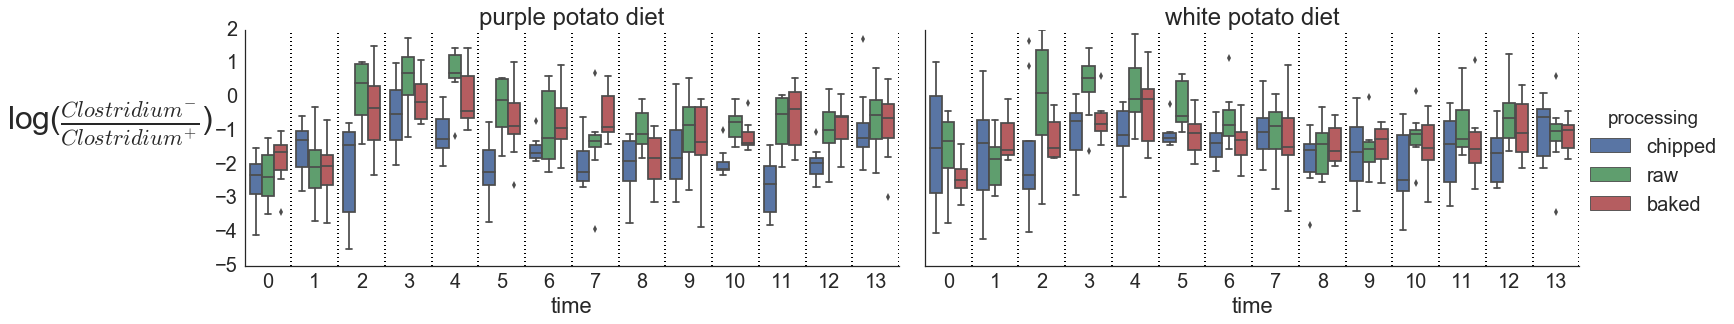

In [109]:
fig = plt.figure(figsize=(10, 10))
sns.set(font_scale=2)  
sns.set_style('white')
a = sns.factorplot(y=minb, x='time', hue='processing', col='color', 
                   data=data, kind='box', 
                   size=5, aspect=2)
a.axes[0][0].set_ylabel(r"log($\frac{Clostridium^{-}}{Clostridium^{+}}$)", 
                        fontsize=32, rotation=0, labelpad=105)
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)

minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.savefig('../figures/subfigures/clostridium.pdf')

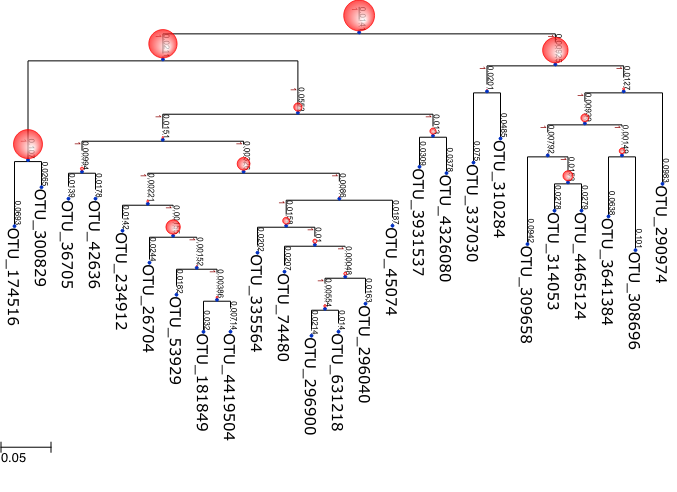

In [95]:
# Convert the p-values to negative log for better visualization.
column_name = "C(processing, Treatment(reference='chipped'))[T.baked]"
p = -np.log(sub_pvals[column_name].astype(np.float))

# Plot the balances for the subtree.
tr, ts = balanceplot(balances=p, tree=subtree, mode='r')  
ts.branch_vertical_margin = 10
ts.rotation=90
tr.render(file_name='../figures/subfigures/clostridium_tree.pdf', tree_style=ts, layout=layout) 
tr.render(file_name='%%inline', tree_style=ts, layout=layout) 

In [96]:
norm_table = otu_table.apply(lambda x: x / x.sum(), axis=1)
otu_data = pd.merge(norm_table, data, left_index=True, right_index=True)

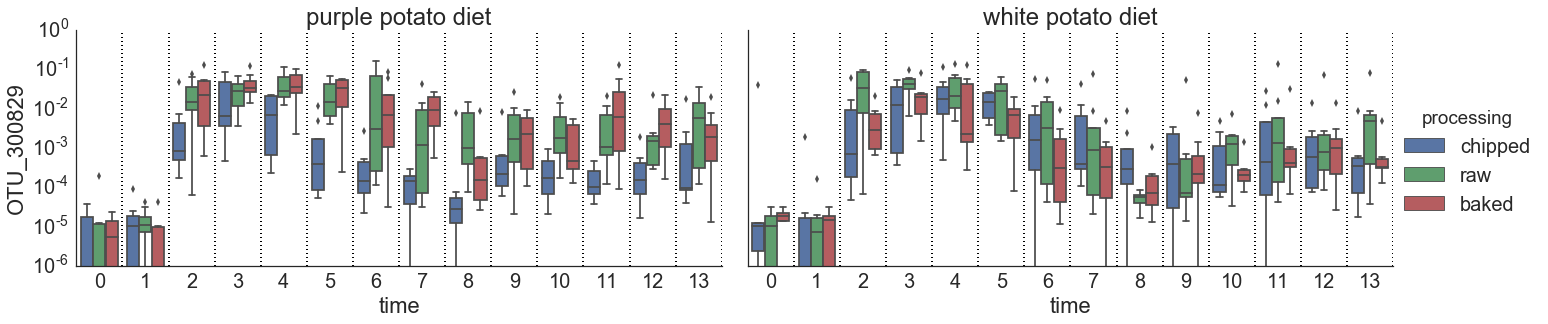

In [97]:
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=2) 
sns.set_style('white')
a = sns.factorplot(y='300829', x='time', hue='processing', col='color', data=otu_data, kind='box', size=5, aspect=2)
a.axes[0][0].set_ylabel('OTU_300829')
a.axes[0][0].set_yscale('log')
a.axes[0][1].set_yscale('log') 
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)
minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.savefig('../figures/subfigures/OTU_300829.pdf')

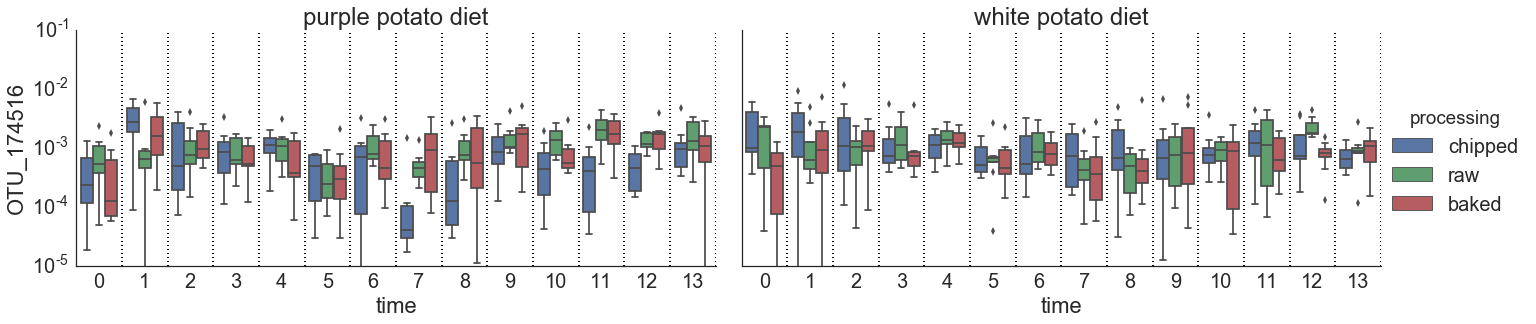

In [98]:
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=2)
sns.set_style('white')

a = sns.factorplot(y='174516', x='time', hue='processing', col='color', data=otu_data, kind='box', size=5, aspect=2)
a.axes[0][0].set_ylabel('OTU_174516')
a.axes[0][0].set_yscale('log')
a.axes[0][1].set_yscale('log')
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)
minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.savefig('../figures/subfigures/OTU_174516.pdf')
#a.savefig('../results/chipped_%s_plot.pdf' % minb)

# Mogibacteriaceae

In [99]:
minb = 'y543'
nodes = {n.name:n for n in otu_tree.levelorder()}
subtree = nodes[minb] 
tips = [n.name for n in subtree.tips()]
non_tips = [n.name for n in subtree.levelorder() if not n.is_tip()]
sub_pvals = res.pvalues.loc[non_tips]

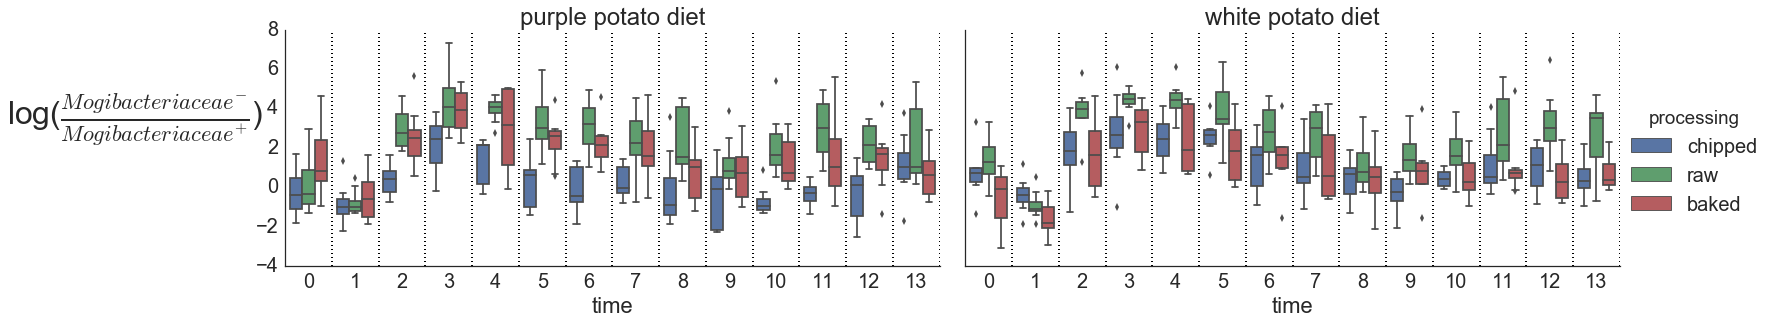

In [105]:
fig = plt.figure(figsize=(10, 5))
sns.set_style('white')

a = sns.factorplot(y=minb, x='time', hue='processing', col='color', 
                   data=data, kind='box', 
                   size=5, aspect=2)
a.axes[0][0].set_ylabel(r"log($\frac{Mogibacteriaceae^{-}}{Mogibacteriaceae^{+}}$)", 
                        fontsize=32, rotation=0, labelpad=120)
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)

minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)

a.savefig('../figures/subfigures/mogibacteriaceae.pdf')

In [101]:
taxonomy.loc[[n.name for n in nodes[minb].children[0].tips()]]

,kingdom,phylum,class,order,family,genus,species
302433,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
4455005,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
36792,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
300285,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
4311953,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
33133,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
208539,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
673084,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
351498,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
97639,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__


In [102]:
taxonomy.loc[[n.name for n in nodes[minb].children[1].tips()]]

,kingdom,phylum,class,order,family,genus,species
300588,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
23113,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
811513,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
2176015,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__Mogibacterium,s__
1084643,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__Mogibacterium,s__
324882,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__


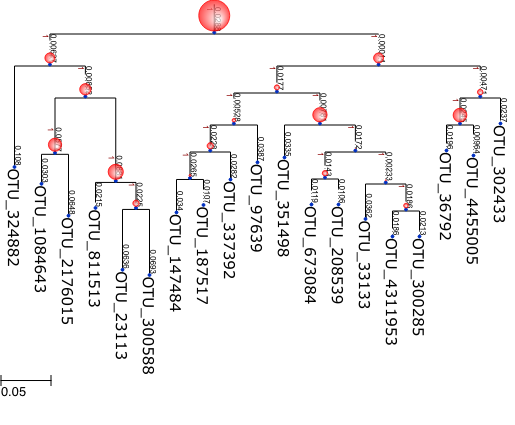

In [103]:
# Convert the p-values to negative log for better visualization.
column_name = "C(processing, Treatment(reference='chipped'))[T.baked]"
p = -np.log(sub_pvals[column_name].astype(np.float))

# Plot the balances for the subtree.
tr, ts = balanceplot(balances=p, tree=subtree, mode='r')  
ts.branch_vertical_margin = 10
ts.rotation=90
tr.render(file_name='../figures/subfigures/mogibacteriaceae_tree.pdf', tree_style=ts, layout=layout) 
tr.render(file_name='%%inline', tree_style=ts, layout=layout) 